In [1]:
##### __Author__ = "Askar Babu U"
##### __Version__ = "1.0"
##### __Email__ = "askarbx2020@email.iimcal.ac.in"
##### __Last updated__ =8/18/2021

     The objective of this script is to develop a tool to determine whether a property is underpriced, fairly priced or overpriced.We will be using a technique called quantile regression to predict conditional 95th percentile and 5th percentile of the property prices, given the predictor variables. Any properties which lie between the two decision boundaries will be considered as fairly valued. Properties whose quoted price is higher than the predicted 95th percentile would be overvalued. Properties whose quoted price is lesser than the predicted 5th percentile would be grouped as undervalued. Although We will be using Gradient Boosted Trees to implement the quantile regression in this perticular script, other techniques can also be tried out     

<h3> Read and Understand the data

In [2]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

# Import the numpy and pandas package

import numpy as np
import pandas as pd

# Import libraries for data visualisation

import matplotlib.pyplot as plt 
import seaborn as sns

#suppress scientific notation while displaying

pd.set_option('display.float_format', lambda x: f'{x:,.1f}')

In [3]:
#load the dataset

property_df = pd.read_csv('data_science_challenge_data.csv')
property_df.index.name = 'ppty_id'

The dataset were already explored in the price prediction model script and the analysis are not repeated here

In [4]:
property_df

,neighbourhood,price,size,bedrooms,bathrooms,building
ppty_id,,,,,,
0,SNR,"130,000.0","1,300.0",2,3.0,Building_263
1,ZMS,"140,000.0","1,185.0",1,2.0,Building_25
2,ZMS,"250,000.0","2,050.0",3,5.0,Building_324
3,ZMS,"250,000.0","3,860.0",4,5.0,Building_353
4,SNR,"170,000.0","1,896.0",3,4.0,Building_280
...,...,...,...,...,...,...
67102,ZMS,"120,000.0",830.0,1,2.0,Building_69
67103,ZMS,"110,000.0",923.0,1,2.0,Building_320
67104,ZMS,"135,000.0","1,196.0",2,3.0,Building_240


    Modelling contains following steps 
    1.Remove outliers in predictor variables
    2.Train-prediction split
    3.Categorical encoding
    4.Null value treatment 
    5.model training
    6.prediction

<h3> Modelling for conditional percentiles 

<h4>1.Remove outliers in predictor variables

Quantile regression is part of a group of techniques called robust regressions and are not influenced by outliers in the response variable.Nevertheless we will have to treat the predictor variables for outliers

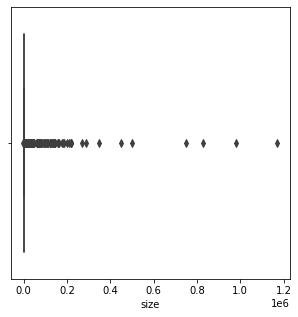

In [5]:
# Outlier Analysis for size

fig, axs = plt.subplots(1,1, figsize = (5,5))
plt1 = sns.boxplot(property_df['size'])

plt.show()

In [6]:
property_df.quantile(0.95)

price       260,000.0
size          2,862.4
bedrooms          3.0
bathrooms         4.0
Name: 0.95, dtype: float64

Every properties having more than 2800 as size or a non positive number as size is also considered as an outlier 

In [7]:
#dataset after removing outliers in size 

property_df = property_df[(property_df['size'] <= 2800 ) & (property_df['size'] > 0.0 )]

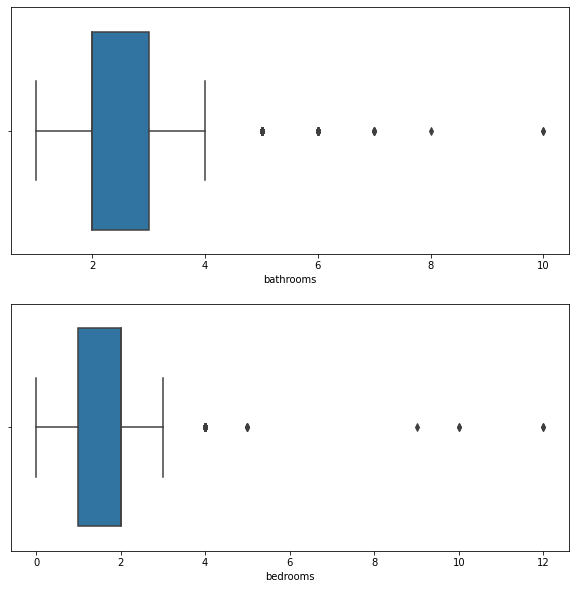

In [8]:
# Outlier Analysis for bathrooms and bedrooms

fig, axs = plt.subplots(2,1, figsize = (10,10))
plt1 = sns.boxplot(property_df['bathrooms'], ax = axs[0])
plt1 = sns.boxplot(property_df['bedrooms'], ax = axs[1])

plt.show()

Every properties having more than 4 bathrooms or 3 bedrooms are treated as outliers

In [9]:
#dataset after removing outliers in bedrooms and bathrooms

property_df = property_df[(property_df['bathrooms'] <= 4.0 ) & (property_df['bedrooms'] <= 3.0 )]

In [10]:
property_df.describe()

,price,size,bedrooms,bathrooms
count,"58,924.0","58,924.0","58,924.0","58,924.0"
mean,"210,894.1","1,187.0",1.5,2.2
std,"6,235,372.7",497.1,0.9,0.9
min,"22,000.0",1.0,0.0,1.0
25%,"95,000.0",802.0,1.0,2.0
50%,"125,000.0","1,107.0",1.0,2.0
75%,"155,000.0","1,500.0",2.0,3.0
max,"565,352,964.0","2,800.0",3.0,4.0


<h4>2.Train-prediction split

model would be trained on the train set and would be used to predict on the predcition set. All properties which needs to be grouped as 'Overvalued','Undervalued','Fairly valued' should be part of the prediction set.here, we would be doing a random split of the properties  

In [11]:
#import necessary libraries

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split

/DATADISKJUPYTERHUB/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/DATADISKJUPYTERHUB/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#dep

In [12]:
# train-prediction split 

train, test = train_test_split(property_df, test_size=0.2, random_state=121)

**3. Encoding categorical variables** 

* Mean encoding `building` 

In [13]:
#obtain mean property price for each building in train data 

encod_type = train.groupby('building')['price'].mean()

#create a new column with mean property price of the building

train['building_mean_enc'] = train['building'].map(encod_type)
train = train.drop('building',axis =1)

#use the same mean values to encode building in test data

test['building_mean_enc'] = test['building'].map(encod_type)
test = test.drop('building',axis =1)

* Label encoding `bedrooms` and `bathrooms`

In [14]:
label_encoder = LabelEncoder()

#encode bedrooms
train['bedrooms'] = label_encoder.fit_transform(train['bedrooms'])
test['bedrooms'] = label_encoder.transform(test['bedrooms'])

#encode bathrooms
train['bathrooms'] = label_encoder.fit_transform(train['bathrooms'])
test['bathrooms'] = label_encoder.transform(test['bathrooms'])

* One hot encoding `neighbourhood`

In [15]:
train['neighbourhood_SNR'] = np.where((train.neighbourhood == 'SNR'), 1, 0)
train['neighbourhood_ZMS'] = np.where((train.neighbourhood == 'ZMS'), 1, 0)
train = train.drop('neighbourhood',axis =1)

In [16]:
test['neighbourhood_SNR'] = np.where((test.neighbourhood == 'SNR'), 1, 0)
test['neighbourhood_ZMS'] = np.where((test.neighbourhood == 'ZMS'), 1, 0)
test = test.drop('neighbourhood',axis =1)

<h4>4.Null value treatment

In [17]:
# Checking Null values

test.isnull().sum()

price                   0
size                    0
bedrooms                0
bathrooms               0
building_mean_enc    1088
neighbourhood_SNR       0
neighbourhood_ZMS       0
dtype: int64

In [18]:
#Null values in building_mean_enc are treated
#nulls values are replaced with the average of property price in an average building 

mean_values = train.mean()
train = train.fillna(mean_values)
test = test.fillna(mean_values)

<h4>5.Model training

In [19]:
#get the predictors and the response variable 

X_train = train.loc[:, train.columns != 'price']
y_train = train['price']

X_test = test.loc[:, test.columns != 'price']
y_test = test['price']

In [20]:
#Fit GBT model for 95th percentile

warnings.filterwarnings('ignore')

alpha = 0.95

clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)

clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.95, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='quantile', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=9, min_samples_split=9,
                          min_weight_fraction_leaf=0.0, n_estimators=250,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [21]:
# Make the 95th percentile prediction

y_upper = clf.predict(X_test)

In [22]:
#Fit model for 5th percentile

clf.set_params(alpha=1.0 - alpha)
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.050000000000000044, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='quantile',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=9, min_samples_split=9,
                          min_weight_fraction_leaf=0.0, n_estimators=250,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
# Make the 5th percentile prediction

y_lower = clf.predict(X_test)

In [24]:
#Create a new dataframe containing quoted price,upper limit,lower limit

y_upper = np.round(y_upper, 1) 
y_lower = np.round(y_lower, 1) 
valuation_df = pd.DataFrame({'price_quoted':y_test, 'predicted-95th percentile':y_upper, 
                                                    'predicted-5th percentile':y_lower })

In [25]:
#Any properties which lie between the two decision boundaries will be considered as fairly valued. 
#Properties whose quoted price is higher than the predicted 95th percentile would be overvalued
#Properties whose quoted price is lesser than the predicted 5th percentile would be grouped as undervalued

valuation_df['valuation'] = np.where((valuation_df.price_quoted > valuation_df['predicted-95th percentile'] ), 'Overvalued',
                           (np.where((valuation_df.price_quoted < valuation_df['predicted-5th percentile'] ), 'Undervalued',
                            'Fairly valued')))

A representative picture with a random sample of 500 properties and size as the predictor variable are created below. please note actual GBT model uses all independent variables provided in the dataset to accurately predict the decision boundaries 

In [26]:
valuation_df['size']=X_test['size']

#selected a set of data points to illustarte the technique 

df = valuation_df[(valuation_df['price_quoted']<205000.0) & (valuation_df['predicted-95th percentile']<241639.0)]
df = df.sample(500)

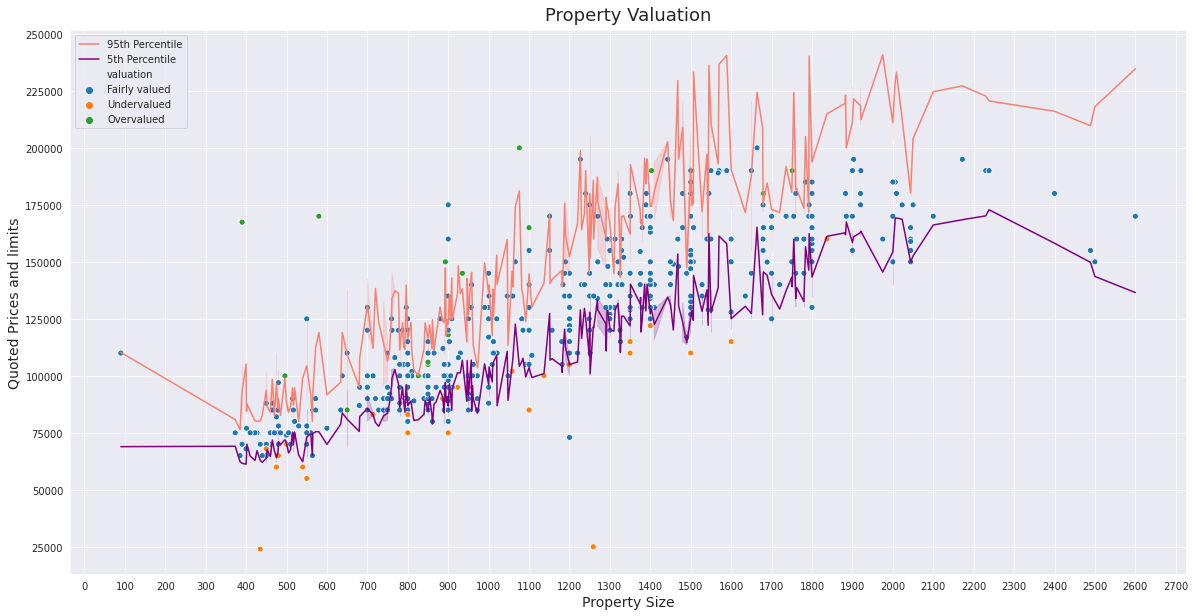

In [28]:
#plot the price vs size scatter
#plot the upper limit
#plot the lower limit 

from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(20, 10))


sns.set_style("dark")
sns.axes_style("whitegrid")

#plot the price vs size scatter

ax = sns.scatterplot(data=df, x="size", y="price_quoted",hue ='valuation' )

#set gris locations

ax.xaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_major_locator(MultipleLocator(25000))

#plot the boundaries

sns.lineplot(x=df['size'], y=df['predicted-95th percentile'],color = 'salmon',label=u'95th Percentile')
sns.lineplot(x=df['size'], y=df['predicted-5th percentile'],color = 'purple',label=u'5th Percentile')

#set axis labels and titles

plt.xlabel('Property Size',fontsize=14)
plt.ylabel('Quoted Prices and limits',fontsize=14)
plt.title('Property Valuation', fontdict={'fontsize':18}, pad=10)
plt.grid()
plt.legend(loc='upper left')

plt.savefig('valuation.png')
plt.show()

Scatter plot showing property size vs quoted price is overlaid with model predicted boundaries. Each dot is a property. Salmon color boundary is the predicted conditional 95th percentile of the property prices while purple one is the conditional  5th percentile. All properties above salmon color boundary are overvalued and that below the purple boundary are undervalued. 